In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from PIL import Image
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet

from PIL import Image
#from albumentations.pytorch import ToTensor 
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import sys
import sklearn

import cv2
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from torchvision import models, transforms
from torch.utils.data import WeightedRandomSampler

import matplotlib.pyplot as plt



IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)


'''
IMAGE TRANSFORMS
'''
class ImageTransform:
    def __init__(self, size, mean, std):
        self.data_transform = transforms.Compose([
                transforms.Resize((size, size), interpolation=Image.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

    def __call__(self, img):
        return self.data_transform(img)


In [2]:
transformer = ImageTransform(IMG_SIZE, mean, std)

In [3]:
device = 'cuda'
import timm
model = timm.create_model('xception', pretrained=True, num_classes=1)
model = model.to(device)

# Load the model state
deepfake_types = ['Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures']

c:\Users\Sheryl\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


In [4]:
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0
    criterion = torch.nn.BCEWithLogitsLoss()  # Binary classification loss

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move data to the correct device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Model forward pass
            outputs = model(inputs)
            
            # Ensure outputs and labels have the same shape
            outputs = outputs.view(-1)  # Flatten outputs to match labels
            labels = labels.view(-1).float()  # Flatten labels and convert to float

            # Compute loss
            loss = criterion(outputs.float(), labels)
            total_loss += loss.item()

            # Calculate predictions and accuracy
            predictions = (torch.sigmoid(outputs) > 0.5).long()
            correct += (predictions == labels.long()).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [5]:
def test_model_maxvoting(model, test_loader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0
    criterion = torch.nn.BCEWithLogitsLoss()  # Binary classification loss

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move data to the correct device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Model forward pass
            outputs = model(inputs)
            
            # Ensure outputs and labels have the same shape
            outputs = outputs.view(-1)  # Flatten outputs to match labels
            labels = labels.view(-1).float()  # Flatten labels and convert to float

            # Compute loss
            loss = criterion(outputs.float(), labels)
            total_loss += loss.item()

            # Calculate predictions and accuracy
            predictions = outputs
            correct += (predictions == labels.long()).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [6]:
def test_model_global_dataset(model):
    deepfakes_test_statistics = {}
    for deepfake_type_dataset in deepfake_types:
        DEEPFAKE_TYPE = deepfake_type_dataset
        TEST_FOLDER = fr'D:\FF\crops\{DEEPFAKE_TYPE}\test' 
        test_ds = ImageFolder(root=TEST_FOLDER, transform=transformer)
        test_loader = DataLoader(test_ds, shuffle=False, batch_size=64)

        avg_loss, accuracy = test_model(model, test_loader)
        print(avg_loss, accuracy)
        deepfakes_test_statistics[deepfake_type_dataset] = accuracy
    return deepfakes_test_statistics

def test_model_global_dataset_maxvoting(model):
    deepfakes_test_statistics = {}
    for deepfake_type_dataset in deepfake_types:
        DEEPFAKE_TYPE = deepfake_type_dataset
        TEST_FOLDER = fr'D:\FF\crops\{DEEPFAKE_TYPE}\test' 
        test_ds = ImageFolder(root=TEST_FOLDER, transform=transformer)
        test_loader = DataLoader(test_ds, shuffle=False, batch_size=64)

        avg_loss, accuracy = test_model_maxvoting(model, test_loader)
        print(avg_loss, accuracy)
        deepfakes_test_statistics[deepfake_type_dataset] = accuracy
    return deepfakes_test_statistics

In [7]:
class EnsembleModelMean(nn.Module):
    def __init__(self, models):
        super(EnsembleModelMean, self).__init__()
        self.models = nn.ModuleList(models)  # List of models

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        # Stack outputs from all models (each model's output will be of shape [batch_size, num_classes])
        outputs = torch.stack(outputs, dim=0)
        # Take the mean of the outputs (for regression) or use voting for classification
        return torch.mean(outputs, dim=0)  # For classification, use mean or voting

In [8]:
class EnsembleModelMaxVoting(nn.Module):
    def __init__(self, models):
        super(EnsembleModelMaxVoting, self).__init__()
        self.models = nn.ModuleList(models)  # List of models

    def forward(self, x):
        # Get predictions from all models
        outputs = [model(x) for model in self.models]
        
        # Get predicted class labels for each model (each output is [batch_size, num_classes])
        _, preds = torch.max(torch.stack(outputs, dim=0), dim=2)  # preds is a list of predictions for each model
        
        # Apply max voting: for each input sample, get the majority class label
        final_preds = torch.mode(preds, dim=0)[0]  # The mode (most common value) across all models
        return final_preds

In [10]:
deepfakes_test_statistics = {}
for deepfake_type_dataset in deepfake_types:
    DEEPFAKE_TYPE = deepfake_type_dataset
    TEST_FOLDER = fr'D:\FF\crops\{DEEPFAKE_TYPE}\test' 
    test_ds = ImageFolder(root=TEST_FOLDER, transform=transformer)
    test_loader = DataLoader(test_ds, shuffle=False, batch_size=64)

models = []
for deepfake_type_model in deepfake_types:
    model = timm.create_model('xception', pretrained=True, num_classes=1)
    model = model.to(device)
    checkpoint = torch.load(f'ff_xceptionnet_1fc_{deepfake_type_model}_10epoch.pth')
    model.load_state_dict(checkpoint["model_state"])
    models.append(model)
ensemblemaxvote = EnsembleModelMaxVoting(models)
ensemblemaxvote.to(device)
ensemblemean = EnsembleModelMean(models)
ensemblemean.to(device)


C:\Users\Sheryl\AppData\Local\Temp\ipykernel_5308\2005023501.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'ff_xceptionnet_1fc_{deepfake_type

EnsembleModelMean(
  (models): ModuleList(
    (0-4): 5 x Xception(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (block1): Block(
        (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rep): Sequential(
          (0): SeparableConv2d(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def plot_model_global(model, title):
    deepfakes_test_statistics = test_model_global_dataset(model)
    # Convert data to a numpy array for heatmap
    labels = list(deepfakes_test_statistics.keys())
    values = np.array([deepfakes_test_statistics[j] for j in deepfake_types]).reshape(1, -1)

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(values, annot=True, cmap="YlGnBu", xticklabels=deepfake_types, fmt=".2f")
    title = title if title else "Model Performance against Datasets"
    plt.title(title)
    plt.xlabel("Dataset Type")
    plt.ylabel("Model Type")
    plt.show()

def plot_model_global_maxvoting(model, title):
    deepfakes_test_statistics = test_model_global_dataset_maxvoting(model)
    # Convert data to a numpy array for heatmap
    labels = list(deepfakes_test_statistics.keys())
    values = np.array([deepfakes_test_statistics[j] for j in deepfake_types]).reshape(1, -1)

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(values, annot=True, cmap="YlGnBu", xticklabels=deepfake_types, fmt=".2f")
    title = title if title else "Model Performance against Datasets"
    plt.title(title)
    plt.xlabel("Dataset Type")
    plt.ylabel("Model Type")
    plt.show()

0.6958940935475256 0.6680171055593068
1.0803577613418123 0.5584897179458366
1.092134574897212 0.5540555743053212
1.6825415787919025 0.4980330448465775
1.0204212934535881 0.581646423751687


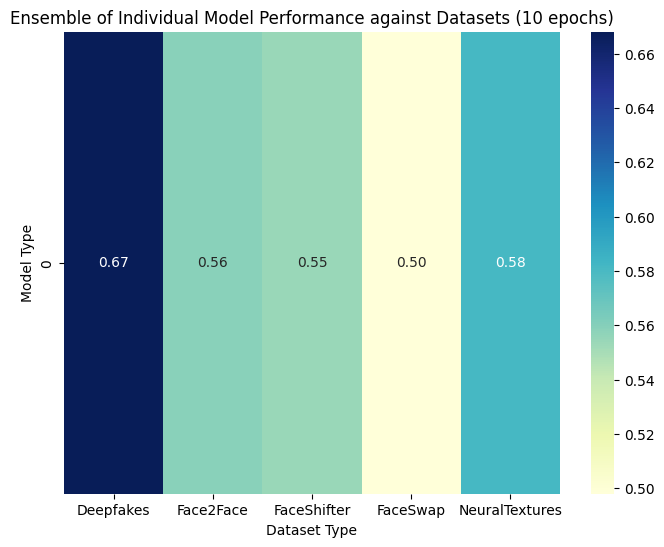

In [ ]:
plot_model_global(ensemblemean, 'Ensemble of Individual Model Performance against Datasets (10 epochs)')


# early stopping in local models for fedavg - comm rounds also early stopping
# do fedsgd and fedprox (alka will send code)
# compare with ensemble (bagging/maxvote) - to send to alka
# compare with boosting (sequential training)
# rerun with augment dataset and noise

0.6931471824645996 0.49932478055367996
0.6931471824645996 0.5000561860883246
0.69314718289341 0.4994937563280459
0.6931471824645996 0.4999438012813308
0.6931471824645996 0.49966261808367074


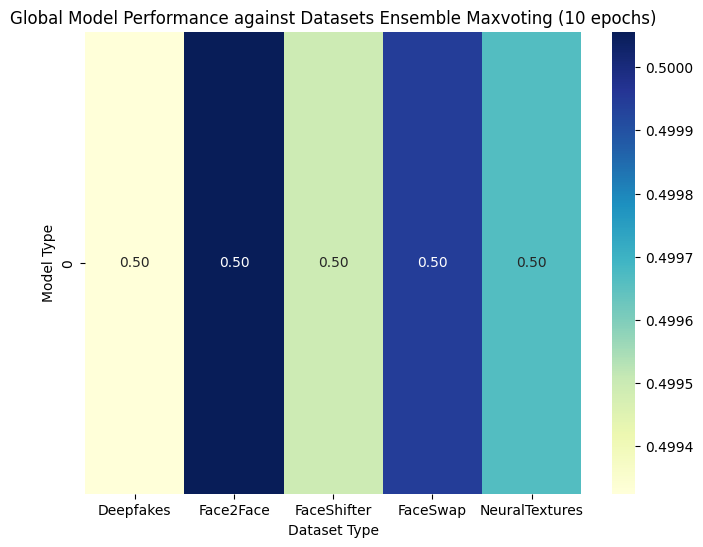

In [13]:
plot_model_global_maxvoting(ensemblemaxvote, 'Global Model Performance against Datasets Ensemble Maxvoting (10 epochs)')